In [15]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import torch
import tensorflow as tf

SOURCE_PATH = "data-source/parkinsons"

#ORA PUOI PROSEGUIRE CON LSTM

In [16]:
def profile_dataframe(df, name='DataFrame'):
    print(f'\n=== Profiling {name} ===')
    print(f'Total Rows: {len(df)}')
    print(f'Total Columns: {len(df.columns)}\n')
    
    profile_results = []

    for col in df.columns:
        series = df[col]
        col_dtype = series.dtype
        
        # Basic counts
        total_count = len(series)
        missing_vals = series.isna().sum()
        non_null_count = total_count - missing_vals
        missing_perc = (missing_vals / total_count) * 100
        unique_vals = series.nunique(dropna=False)
        
        # Mode & frequency
        try:
            modes = series.mode(dropna=True)
            mode_val = modes.iloc[0] if len(modes) > 0 else np.nan
            mode_freq = (series == mode_val).sum(skipna=True)
        except:
            mode_val, mode_freq = np.nan, np.nan
        
        # Initialize placeholders
        mean_ = np.nan
        min_  = np.nan
        q25   = np.nan
        q50   = np.nan
        q75   = np.nan
        max_  = np.nan
        std_  = np.nan  # only for numeric columns

        # Numeric columns
        if pd.api.types.is_numeric_dtype(series):
            mean_ = series.mean(skipna=True)
            min_  = series.min(skipna=True)
            q25   = series.quantile(0.25)
            q50   = series.quantile(0.50)
            q75   = series.quantile(0.75)
            max_  = series.max(skipna=True)
            std_  = series.std(skipna=True)

        # Datetime columns
        elif pd.api.types.is_datetime64_any_dtype(series):
            # We can compute mean & quartiles by time. 
            # .quantile() and .mean() are valid for datetime in pandas
            # They return a Timestamp for mean, 
            # and Timestamps for quantiles
            if non_null_count > 0:
                mean_ = series.mean(skipna=True)
                min_  = series.min(skipna=True)
                q25   = series.quantile(0.25)
                q50   = series.quantile(0.50)
                q75   = series.quantile(0.75)
                max_  = series.max(skipna=True)
            # We skip std_ for datetime.

        # Categorical/object columns 
        # do not get numeric stats (we keep them as NaN).

        profile_results.append((
            col,
            str(col_dtype),
            total_count,
            non_null_count,
            missing_vals,
            round(missing_perc, 2),
            unique_vals,
            mode_val,
            mode_freq,
            mean_,
            min_,
            q25,
            q50,
            q75,
            max_,
            std_
        ))

    columns = [
        'Column', 'DataType', 'TotalCount', 'NonNullCount', 'NumMissing',
        'MissingPerc', 'Cardinality', 'Mode', 'ModeFreq',
        'Mean', 'Min', 'Q25', 'Q50', 'Q75', 'Max', 'Std'
    ]

    prof_df = pd.DataFrame(profile_results, columns=columns)
    
    return prof_df

In [17]:
df = pd.read_csv(f"{SOURCE_PATH}/telemonitoring/parkinsons_updrs.data")
df2 = pd.read_csv(f"{SOURCE_PATH}/parkinsons.data")

In [18]:
df_profile = profile_dataframe(df, name='NTSB Data')
display(HTML(df_profile.to_html()))


=== Profiling NTSB Data ===
Total Rows: 5875
Total Columns: 22



,Column,DataType,TotalCount,NonNullCount,NumMissing,MissingPerc,Cardinality,Mode,ModeFreq,Mean,Min,Q25,Q50,Q75,Max,Std
0,subject#,int64,5875,5875,0,0.0,42,29.000000,168,21.494128,1.000000,10.000000,22.000000,33.000000,42.000000,12.372279
1,age,int64,5875,5875,0,0.0,23,58.000000,429,64.804936,36.000000,58.000000,65.000000,72.000000,85.000000,8.821524
2,sex,int64,5875,5875,0,0.0,2,0.000000,4008,0.317787,0.000000,0.000000,0.000000,1.000000,1.000000,0.465656
3,test_time,float64,5875,5875,0,0.0,2442,119.340000,15,92.863722,-4.262500,46.847500,91.523000,138.445000,215.490000,53.445602
4,motor_UPDRS,float64,5875,5875,0,0.0,1080,15.000000,143,21.296229,5.037700,15.000000,20.871000,27.596500,39.511000,8.129282
5,total_UPDRS,float64,5875,5875,0,0.0,1129,32.000000,109,29.018942,7.000000,21.371000,27.576000,36.399000,54.992000,10.700283
6,Jitter(%),float64,5875,5875,0,0.0,1305,0.004400,22,0.006154,0.000830,0.003580,0.004900,0.006800,0.099990,0.005624
7,Jitter(Abs),float64,5875,5875,0,0.0,4105,0.000022,7,0.000044,0.000002,0.000022,0.000035,0.000053,0.000446,0.000036
8,Jitter:RAP,float64,5875,5875,0,0.0,853,0.001930,37,0.002987,0.000330,0.001580,0.002250,0.003290,0.057540,0.003124
9,Jitter:PPQ5,float64,5875,5875,0,0.0,840,0.001750,32,0.003277,0.000430,0.001820,0.002490,0.003460,0.069560,0.003732


In [7]:
df2_profile = profile_dataframe(df2, name='NTSB Data')
display(HTML(df2_profile.to_html()))


=== Profiling NTSB Data ===
Total Rows: 195
Total Columns: 24



,Column,DataType,TotalCount,NonNullCount,NumMissing,MissingPerc,Cardinality,Mode,ModeFreq,Mean,Min,Q25,Q50,Q75,Max,Std
0,name,object,195,195,0,0.0,195,phon_R01_S01_1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MDVP:Fo(Hz),float64,195,195,0,0.0,195,88.333,1,154.228641,88.333000,117.572000,148.790000,182.769000,260.105000,41.390065
2,MDVP:Fhi(Hz),float64,195,195,0,0.0,195,102.145,1,197.104918,102.145000,134.862500,175.829000,224.205500,592.030000,91.491548
3,MDVP:Flo(Hz),float64,195,195,0,0.0,195,65.476,1,116.324631,65.476000,84.291000,104.315000,140.018500,239.170000,43.521413
4,MDVP:Jitter(%),float64,195,195,0,0.0,173,0.00369,3,0.006220,0.001680,0.003460,0.004940,0.007365,0.033160,0.004848
5,MDVP:Jitter(Abs),float64,195,195,0,0.0,19,0.00003,46,0.000044,0.000007,0.000020,0.000030,0.000060,0.000260,0.000035
6,MDVP:RAP,float64,195,195,0,0.0,155,0.00169,5,0.003306,0.000680,0.001660,0.002500,0.003835,0.021440,0.002968
7,MDVP:PPQ,float64,195,195,0,0.0,165,0.00332,4,0.003446,0.000920,0.001860,0.002690,0.003955,0.019580,0.002759
8,Jitter:DDP,float64,195,195,0,0.0,180,0.00507,3,0.009920,0.002040,0.004985,0.007490,0.011505,0.064330,0.008903
9,MDVP:Shimmer,float64,195,195,0,0.0,188,0.0145,2,0.029709,0.009540,0.016505,0.022970,0.037885,0.119080,0.018857


In [8]:
df.loc[df['test_time']==5.6431]

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
24,1,72,0,5.6431,28.199,34.398,0.00348,0.000015,0.00124,0.00133,...,0.113,0.00411,0.00463,0.00949,0.01234,0.009238,27.927,0.37340,0.52499,0.17066


In [9]:
df_filtered = df[(df['test_time'] < 0)]
df_filtered.style.map(
    lambda val: 'background-color: red' if val < 0 else '',
    subset=['test_time']
)

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
4531,34,59,0,-3.312500,29.291000,34.146000,0.004410,0.000037,0.002020,0.002390,0.006070,0.020970,0.178000,0.010430,0.010630,0.018500,0.031280,0.031377,19.613000,0.663280,0.646330,0.181480
4557,34,59,0,-3.311800,29.291000,34.146000,0.002250,0.000018,0.001080,0.001390,0.003240,0.014820,0.126000,0.007500,0.008760,0.013880,0.022490,0.004839,24.733000,0.546710,0.669100,0.118490
4584,34,59,0,-3.311800,29.291000,34.146000,0.003880,0.000031,0.002010,0.001830,0.006020,0.022460,0.200000,0.012480,0.012510,0.018690,0.037430,0.019934,22.683000,0.477440,0.668110,0.163630
4611,34,59,0,-3.310400,29.291000,34.146000,0.006170,0.000058,0.003220,0.003280,0.009650,0.024940,0.217000,0.012690,0.015350,0.026940,0.038060,0.030033,18.866000,0.692740,0.681880,0.243240
4638,34,59,0,-3.309700,29.291000,34.145000,0.003530,0.000028,0.001590,0.001800,0.004780,0.039190,0.366000,0.020350,0.023400,0.029630,0.061050,0.016998,22.557000,0.539590,0.637690,0.142060
4665,34,59,0,-3.309700,29.291000,34.145000,0.002660,0.000019,0.001340,0.001580,0.004030,0.034040,0.314000,0.017760,0.019850,0.025860,0.053280,0.011116,24.287000,0.534660,0.602630,0.146820
5725,42,61,0,-4.262500,19.725000,28.633000,0.015330,0.000118,0.007740,0.008000,0.023230,0.113980,0.908000,0.059040,0.053150,0.045760,0.177130,0.132810,11.689000,0.702730,0.669750,0.484660
5750,42,61,0,-4.262500,19.725000,28.633000,0.006150,0.000046,0.002660,0.002910,0.007980,0.034970,0.316000,0.019070,0.022290,0.031090,0.057210,0.014472,21.127000,0.494110,0.700680,0.229850
5775,42,61,0,-4.261800,19.725000,28.633000,0.006260,0.000048,0.003000,0.002740,0.008990,0.022180,0.200000,0.009840,0.011050,0.018200,0.029530,0.033013,24.559000,0.479910,0.655970,0.225850
5800,42,61,0,-4.260400,19.725000,28.634000,0.005290,0.000044,0.002430,0.002750,0.007280,0.025920,0.225000,0.012220,0.014700,0.021190,0.036670,0.030559,21.910000,0.523720,0.661310,0.212830


In [10]:
df.loc[df['subject#']==42]

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
5725,42,61,0,-4.26250,19.725,28.633,0.01533,0.000118,0.00774,0.00800,...,0.908,0.05904,0.05315,0.04576,0.17713,0.132810,11.689,0.70273,0.66975,0.48466
5726,42,61,0,0.39583,20.026,29.034,0.00327,0.000029,0.00124,0.00166,...,0.179,0.00916,0.01154,0.01890,0.02749,0.007624,23.109,0.59520,0.59125,0.15825
5727,42,61,0,9.71040,20.626,29.835,0.01732,0.000108,0.00839,0.00810,...,1.139,0.06688,0.08070,0.08343,0.20065,0.163430,12.365,0.74874,0.66782,0.48150
5728,42,61,0,16.70800,21.078,30.437,0.00626,0.000052,0.00258,0.00329,...,0.699,0.03911,0.04254,0.06426,0.11732,0.037384,16.169,0.65957,0.66943,0.25474
5729,42,61,0,23.75800,21.533,31.044,0.00477,0.000038,0.00242,0.00258,...,0.392,0.02653,0.02661,0.03154,0.07960,0.026170,20.117,0.56949,0.65745,0.21183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,42,61,0,142.79000,22.485,33.485,0.00406,0.000031,0.00167,0.00168,...,0.160,0.00973,0.01133,0.01549,0.02920,0.025137,22.369,0.64215,0.55314,0.21367
5871,42,61,0,149.84000,21.988,32.988,0.00297,0.000025,0.00119,0.00147,...,0.215,0.01052,0.01277,0.01904,0.03157,0.011927,22.886,0.52598,0.56518,0.12621
5872,42,61,0,156.82000,21.495,32.495,0.00349,0.000025,0.00152,0.00187,...,0.244,0.01371,0.01456,0.01877,0.04112,0.017701,25.065,0.47792,0.57888,0.14157
5873,42,61,0,163.73000,21.007,32.007,0.00281,0.000020,0.00128,0.00151,...,0.131,0.00693,0.00870,0.01307,0.02078,0.007984,24.422,0.56865,0.56327,0.14204


### ✅ Classification (MLP on `parkinsons.data`)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

# Separing features/target
X = df2.drop(columns=["name", "status"]).values
y = df2["status"].values

# Preprocessing
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building MLP model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training
es = EarlyStopping(patience=5, restore_best_weights=True)
model.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[es], verbose=1)

# Valutation
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

Epoch 1/100


/home/antonio/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-30 10:08:59.120259: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.5654 - loss: 0.6885 - val_accuracy: 0.8125 - val_loss: 0.5260
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7747 - loss: 0.5778 - val_accuracy: 0.8125 - val_loss: 0.4802
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8806 - loss: 0.4945 - val_accuracy: 0.8125 - val_loss: 0.4496
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8564 - loss: 0.4594 - val_accuracy: 0.8125 - val_loss: 0.4277
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8419 - loss: 0.4340 - val_accuracy: 0.8125 - val_loss: 0.4091
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8418 - loss: 0.3847 - val_accuracy: 0.8125 - val_loss: 0.3974
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8534 - loss: 0.3612 - val_accuracy: 0.8125 - val_loss: 0.3877
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8544 - loss: 0.3580 - val_accuracy: 0.8125 - val_loss: 0.3798
Epo

#### Interpretazione:

- Accuracy 92% è molto buona su un problema binario (Parkinson vs sano).

- Tuttavia, la macro F1-score di 0.84 suggerisce che uno dei due classi (probabilmente i sani, che sono meno rappresentati) è meno ben classificata.

- Potresti considerare tecniche di data balancing (es. SMOTE) o aggiungere pesatura classi nel training.

### ✅ Regression (MLP on `parkinsons_updrs.data`)

In [24]:
# Escludiamo colonne non vocali
excluded_cols = ["subject#", "age", "sex", "test_time", "motor_UPDRS", "total_UPDRS"]
feature_cols = [col for col in df.columns if col not in excluded_cols]

X = df[feature_cols].values
y = df["total_UPDRS"].values

# Preprocessing
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modello MLP per regressione
model_reg = Sequential([
    Dense(64, activation='relu', input_shape=(X.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

model_reg.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Training
es = EarlyStopping(patience=5, restore_best_weights=True)
model_reg.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[es], verbose=1)

# Valutation
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model_reg.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

Epoch 1/100


/home/antonio/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 835.1636 - mae: 26.5550 - val_loss: 331.5897 - val_mae: 14.6887
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 282.2481 - mae: 13.1394 - val_loss: 175.8658 - val_mae: 10.5144
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 160.1143 - mae: 10.0398 - val_loss: 132.0433 - val_mae: 9.2007
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 134.6476 - mae: 9.3546 - val_loss: 117.8078 - val_mae: 8.7811
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 117.7977 - mae: 8.7474 - val_loss: 110.3756 - val_mae: 8.5915
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 106.2557 - mae: 8.4241 - val_loss: 105.8304 - val_mae: 8.4043
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 109.7237 - mae: 8.5631 - val_loss: 102.8528 - val_mae: 8.2980
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 105.5548 - mae: 8.3059 - val_loss: 99.9596 - val_mae: 8.1385
Epoch 9/100
118/118 ━━━━

#### Interpretazione:

- L’MSE è relativamente alto in relazione ai valori di total_UPDRS che in media sono compresi tra 0 e 150.

- Un R² di 0.29 significa che il modello spiega solo il 29% della varianza → è un risultato debole.

- Probabile causa: il modello MLP non cattura la natura temporale o individuale dei dati (ogni soggetto evolve nel tempo in modo specifico).

### ✅ Building and Training LSTM model

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Raggruppa per soggetto (sto lavorando ora su parkinsons_updrs.data, quindi quello con le serie storiche)
subject_groups = df.groupby("subject#")

sequences = []
targets = []

# Scegliamo le feature vocali
feature_cols = [col for col in df.columns if col not in ["subject#", "age", "sex", "test_time", "motor_UPDRS", "total_UPDRS"]]

for _, group in subject_groups:
    group_sorted = group.sort_values("test_time")
    features = group_sorted[feature_cols].values
    target = group_sorted["total_UPDRS"].values
    if len(features) >= 5:  # Ignora soggetti con poche osservazioni
        sequences.append(features)
        targets.append(target)

# Padding
max_len = max(len(seq) for seq in sequences)
X_padded = pad_sequences(sequences, maxlen=max_len, dtype='float32', padding='post')
y_padded = pad_sequences(targets, maxlen=max_len, dtype='float32', padding='post')

# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_padded, test_size=0.2, random_state=42)

model_lstm = Sequential([
    Masking(mask_value=0.0, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),
    Dense(1)
])


/home/antonio/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### ✅ Predition + Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


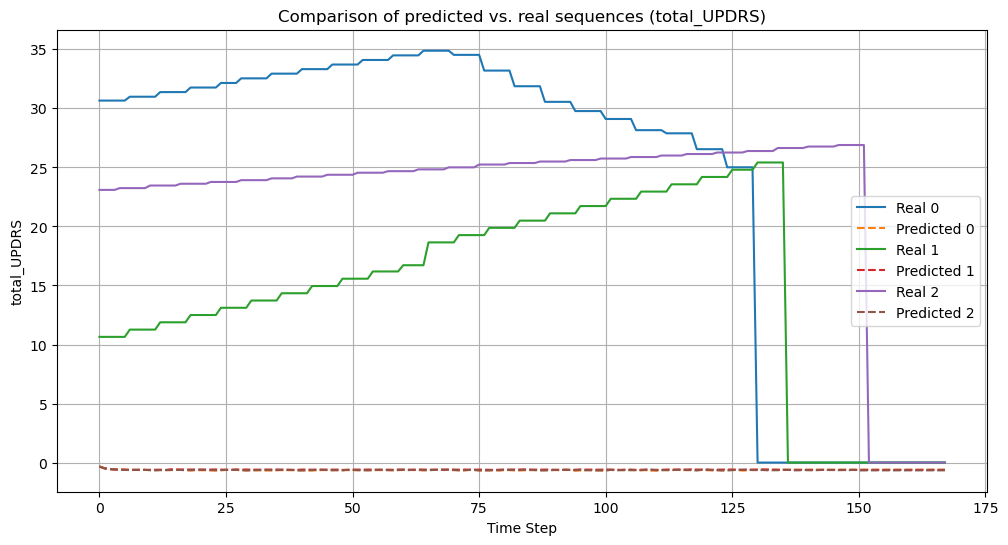

In [28]:
y_pred = model_lstm.predict(X_test)

plt.figure(figsize=(12, 6))
for i in range(3):
    plt.plot(y_test[i], label=f"Real {i}")
    plt.plot(y_pred[i], linestyle="--", label=f"Predicted {i}")
plt.legend()
plt.title("Comparison of predicted vs. real sequences (total_UPDRS)")
plt.xlabel("Time Step")
plt.ylabel("total_UPDRS")
plt.grid(True)
plt.show()

### ✅ Valutation + Saving Data

In [30]:
# Valutation
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()
valid_idx = y_test_flat != 0

mse_lstm = mean_squared_error(y_test_flat[valid_idx], y_pred_flat[valid_idx])
r2_lstm = r2_score(y_test_flat[valid_idx], y_pred_flat[valid_idx])

print("MSE:", mse_lstm)
print("R²:", r2_lstm)

# Saving model
model_lstm.save("lstm_parkinsons_model.h5")

MSE: 843.95215
R²: -9.1850907267949
